In [2]:
"""Backend supported: pytorch, paddle

Implementation of the linear elasticity 2D example in paper https://doi.org/10.1016/j.cma.2021.113741.
References:
    https://github.com/sciann/sciann-applications/blob/master/SciANN-Elasticity/Elasticity-Forward.ipynb.
"""
import deepxde as dde
import numpy as np
from global_constants import L, R, B0, EPS0, MU, LBD, RATIO

lmbd = LBD
mu = MU
Q = 4
Rx = 0.3
Ry = R**2 / Rx

# Define function
if dde.backend.backend_name == "pytorch":
    import torch

    sin = torch.sin
    cos = torch.cos


# Create the domain
rect = dde.geometry.Rectangle([0, 0], [L, L])
hole = dde.geometry.geometry_2d.Ellipse([0, 0], Ry, Rx, 0.5*np.pi)
geom = rect - hole

# Create Boundaries
def boundary_top(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], L)


def boundary_bottom(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 0.0)


def boundary_left(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)


def boundary_right(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], L)


def boundary_hole(x, on_boundary):
    return on_boundary and hole.on_boundary(x)


def boundary_normal(x):
    nx=(x[0])*Ry/Rx
    ny=(x[1])*Rx/Ry
    return [-nx, -ny]

# Exact solutions
def func(x):
    ux = np.cos(2 * np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])
    uy = np.sin(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 4 / 4

    E_xx = -2 * np.pi * np.sin(2 * np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])
    E_yy = np.sin(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 3
    E_xy = 0.5 * (
        np.pi * np.cos(2 * np.pi * x[:, 0:1]) * np.cos(np.pi * x[:, 1:2])
        + np.pi * np.cos(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 4 / 4
    )

    Sxx = E_xx * (2 * mu + lmbd) + E_yy * lmbd
    Syy = E_yy * (2 * mu + lmbd) + E_xx * lmbd
    Sxy = 2 * E_xy * mu

    return np.hstack((ux, uy, Sxx, Syy, Sxy))


ux_left_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_left, component=0)
ux_right_bc = dde.icbc.DirichletBC(geom, lambda x: EPS0 * L, boundary_right, component=0)
uy_bottom_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)
uy_top_bc = dde.icbc.DirichletBC(geom, lambda x: RATIO * EPS0 * L, boundary_top, component=1)
hole_bc = dde.icbc.NeumannBC(geom, lambda x: 0, boundary_hole)
#alter code mit 5 outputs
#hole_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_hole, component=4)


def fx(x):
    return (
        -lmbd
        * (
            4 * np.pi**2 * cos(2 * np.pi * x[:, 0:1]) * sin(np.pi * x[:, 1:2])
            - Q * x[:, 1:2] ** 3 * np.pi * cos(np.pi * x[:, 0:1])
        )
        - mu
        * (
            np.pi**2 * cos(2 * np.pi * x[:, 0:1]) * sin(np.pi * x[:, 1:2])
            - Q * x[:, 1:2] ** 3 * np.pi * cos(np.pi * x[:, 0:1])
        )
        - 8 * mu * np.pi**2 * cos(2 * np.pi * x[:, 0:1]) * sin(np.pi * x[:, 1:2])
    )


def fy(x):
    return (
        lmbd
        * (
            3 * Q * x[:, 1:2] ** 2 * sin(np.pi * x[:, 0:1])
            - 2 * np.pi**2 * cos(np.pi * x[:, 1:2]) * sin(2 * np.pi * x[:, 0:1])
        )
        - mu
        * (
            2 * np.pi**2 * cos(np.pi * x[:, 1:2]) * sin(2 * np.pi * x[:, 0:1])
            + (Q * x[:, 1:2] ** 4 * np.pi**2 * sin(np.pi * x[:, 0:1])) / 4
        )
        + 6 * Q * mu * x[:, 1:2] ** 2 * sin(np.pi * x[:, 0:1])
    )


def pde(x, f):
    E_xx = dde.grad.jacobian(f, x, i=0, j=0)
    E_yy = dde.grad.jacobian(f, x, i=1, j=1)
    E_xy = 0.5 * (dde.grad.jacobian(f, x, i=0, j=1) + dde.grad.jacobian(f, x, i=1, j=0))

    S_xx = E_xx * (2 * mu + lmbd) + E_yy * lmbd
    S_yy = E_yy * (2 * mu + lmbd) + E_xx * lmbd
    S_xy = E_xy * 2 * mu

    Sxx_x = dde.grad.jacobian(f, x, i=2, j=0)
    Syy_y = dde.grad.jacobian(f, x, i=3, j=1)
    Sxy_x = dde.grad.jacobian(f, x, i=4, j=0)
    Sxy_y = dde.grad.jacobian(f, x, i=4, j=1)

    momentum_x = Sxx_x + Sxy_y - B0
    momentum_y = Sxy_x + Syy_y 

    stress_x = S_xx - f[:, 2:3]
    stress_y = S_yy - f[:, 3:4]
    stress_xy = S_xy - f[:, 4:5]

    return [momentum_x, momentum_y, stress_x, stress_y, stress_xy]


data = dde.data.PDE(
    geom,
    pde,
    [
        ux_left_bc,
        ux_right_bc,
        uy_bottom_bc,
        uy_top_bc,
        hole_bc
    ],
    num_domain=500,
    num_boundary=500,
    solution=None,
    num_test=100,
)

layers = [2, [40] * 5, [40] * 5, [40] * 5, [40] * 5, 5]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.PFNN(layers, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

dde.saveplot(losshistory, train_state, issave=False, isplot=True)


Compiling model...
'compile' took 0.000315 s

Training model...



NotImplementedError: Ellipse.boundary_normal to be implemented

0.3
[0.41443403305172466, -0.2602700106032258]
ssss
[0.41443403305172477, -0.2602700106032258]


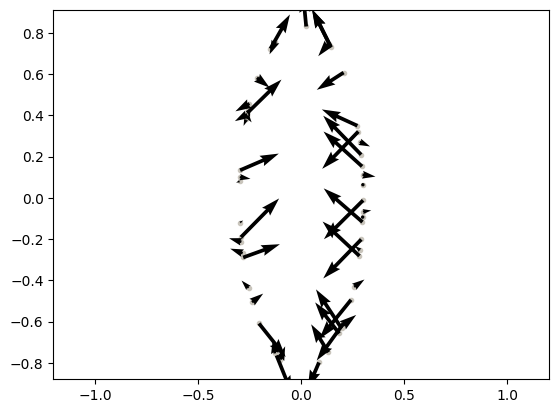

In [ ]:
import matplotlib.pyplot as plt

def boundary_normal(x):
    theta = np.arctan2(x[1]/Ry, x[0]/Rx)
    nx = Ry * np.cos(theta)
    ny = Rx * np.sin(theta)
    return [-nx, -ny]

def boundary_normal2(x):
    nx=(x[0])*Ry/Rx
    ny=(x[1])*Rx/Ry
    return [-nx, -ny]

phi = np.linspace(0, 0.5 * np.pi, int(25 * np.pi * Rx / L))

print(Rx)
hole = dde.geometry.geometry_2d.Ellipse([0, 0], Ry, Rx, 0.5*np.pi)
xxxx = hole.random_boundary_points(50)

print(boundary_normal(xxxx[0]))
print("ssss")
print(boundary_normal2(xxxx[0]))
z = boundary_normal(xxxx[0])
zzz = []
for i in range(0,len(xxxx),1):
    zzz.append(boundary_normal(xxxx[i]))



plt.scatter(xxxx[:,0], xxxx[:,1], marker=".", color="#C9C5BC")
plt.quiver(xxxx[:,0], xxxx[:,1], zzz[0::2], zzz[1::2], color="black")
plt.axis("equal")
plt.show()